#DSCI 417 – Project 03
##Forest Cover Prediction

**Michael Bernier**

##Part A - Set Up Environment
In this part, the working environment will be set up.

Import the tools and classes to be used for the project.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
 
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

Create the SparkSession and SparkContext objects.

In [0]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

##Part B - Load and Explore the Data
In this part we will be loading and exploring the data used for the project. The Forest Cover dataset contains cartographic information from four wilderness areas within the Roosevelt National Forest in northern Colorado. Each observation in the dataset represents a 30-meter x 30-meter square of land. It includes the following columns:

- Elevation – The average elevation of the region in meters.
- Aspect – The direction the slope of the region faces in degrees, with 0 degrees indicating North.
- Slope – The average slope of the region in degrees.
- Horizontal_Distance_To_Hydrology – The horizontal distance to the nearest surface water.
- Vertical_Distance_To_Hydrology – The vertical distance to the nearest surface water.
- Horizontal_Distance_To_Roadways – The horizontal distance to the nearest roadway.
- Hillshade_9am – The amount of shade at 9 am during the summer solstice.
- Hillshade_Noon – The amount of shade at noon during the summer solstice.
- Hillshade_3pm – The amount of shade at 3 pm during the summer solstice.
- Horizontal_Distance_To_Fire_Points – The horizontal distance to the nearest wildfire ignition points.
- Wilderness_Area – The name of the wilderness area the square of land resides in.
- Soil_Type – An integer from 1-40 indicating the predominant soil type.
- Cover_Type – An integer from 1-7 indicating the predominant forest cover type.

Create a custom schema, load the **forest_cover.txt** file into a dataframe, and print the schema.

In [0]:
fc_schema = ' Elevation INTEGER, Aspect INTEGER, Slope INTEGER, Horizontal_Distance_To_Hydrology INTEGER, Vertical_Distance_To_Hydrology INTEGER, \
              Horizontal_Distance_To_Roadways INTEGER, Hillshade_9am INTEGER, Hillshade_Noon INTEGER, Hillshade_3pm INTEGER, Horizontal_Distance_To_Firepoints INTEGER, \
              Wilderness_Area STRING, Soil_Type INTEGER, Cover_Type INTEGER'
 
fc = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .schema(fc_schema)
    .csv('/FileStore/tables/forest_cover.txt')
) 

fc.printSchema()

root
-- Elevation: integer (nullable = true)
-- Aspect: integer (nullable = true)
-- Slope: integer (nullable = true)
-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
-- Vertical_Distance_To_Hydrology: integer (nullable = true)
-- Horizontal_Distance_To_Roadways: integer (nullable = true)
-- Hillshade_9am: integer (nullable = true)
-- Hillshade_Noon: integer (nullable = true)
-- Hillshade_3pm: integer (nullable = true)
-- Horizontal_Distance_To_Firepoints: integer (nullable = true)
-- Wilderness_Area: string (nullable = true)
-- Soil_Type: integer (nullable = true)
-- Cover_Type: integer (nullable = true)

Display the first 3 columns of the dataframe. Because there are so many columns, this will be done by obtaining a list of columns and then splitting them into two pieces.

In [0]:
fc_columns = fc.columns

fc.select(fc_columns[:6]).show(3)
fc.select(fc_columns[6:]).show(3)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
 2596| 51| 3| 258| 0| 510|
 2590| 56| 2| 212| -6| 390|
 2804| 139| 9| 268| 65| 3180|
+---------+------+-----+--------------------------------+------------------------------+-------------------------------+
only showing top 3 rows

+-------------+--------------+-------------+---------------------------------+---------------+---------+----------+
Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Firepoints|Wilderness_Area|Soil_Type|Cover_Type|
+-------------+--------------+-------------+---------------------------------+---------------+---------+----------+
 221| 232| 148| 6279| Rawah| 29| 5|
 220| 235| 151| 6225| Rawah| 29| 5|
 234| 238| 135| 6121| Rawah| 12| 2|
+-------------+--------------+-------------+---------------------------------+---------------+---------+----------+
only showing top 3 rows

Print the number of observations in the dataframe.

In [0]:
N = fc.count()

print('The number of observations in the dataframe is',N)

The number of observations in the dataframe is 15120

Determine the proportion of observations based on **Cover_Type**

In [0]:
fc_by_covertype = (
    fc.groupBy(col('Cover_Type'))
    .agg(
        expr(f'ROUND(COUNT(*)/{N},4) as prop')
     )
        .select('Cover_Type','prop')
).show(truncate=False)

+----------+------+
Cover_Type|prop |
+----------+------+
1 |0.1429|
6 |0.1429|
3 |0.1429|
5 |0.1429|
4 |0.1429|
7 |0.1429|
2 |0.1429|
+----------+------+

##Part C - Preprocessing and Splitting the Data
In this part we will create the stages of a preprocessing pipeline. This pipeline will be used in fitting a Logistic Regression model and a Decision Tree model to the data. After applying the pipeline to the dataframe, the results will then be split into training and testing dataframes. Cover_Type will be used as the label value for both models, and all other columns will be used as features.

Create the stages for the pipeline. There are two vector assemblers: one creates a features vector for Logistic Regression, and the other creates a features vector for Decision Trees.

In [0]:
cat_features = ['Wilderness_Area', 'Soil_Type']
num_features = [c for c in fc.columns[:-1] if c not in cat_features]
 
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]
 
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
 
encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)
 
assembler_lr = VectorAssembler(inputCols=num_features + vec_features, outputCol='features_lr')
assembler_dt = VectorAssembler(inputCols=num_features + ix_features, outputCol='features_dt')

Create the pipeline using the stages created above and apply it to the dataframe, creating a new processed dataframe. Persist the new dataframe, then display the first 5 records of Decision Tree features and labels.

In [0]:
fc_pipe = Pipeline(stages=[feature_indexer, encoder, assembler_lr, assembler_dt]).fit(fc)
fc_proc = fc_pipe.transform(fc)
 
fc_proc.persist()
 
fc_proc.select(['features_dt', 'Cover_Type']).show(5, truncate=False)

+-----------------------------------------------------------------------+----------+
features_dt |Cover_Type|
+-----------------------------------------------------------------------+----------+
[2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,2.0,1.0] |5 |
[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,2.0,1.0] |5 |
[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,2.0,20.0] |2 |
[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,2.0,6.0]|2 |
[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,2.0,1.0] |5 |
+-----------------------------------------------------------------------+----------+
only showing top 5 rows

Split the processed dataframe into two smaller dataframes called **train** and **test**. The **train** dataframe contains 80% of the observations and will be used to train both the Linear Regression and Decision Tree models. The **test** dataframe contains 20% of the observations and will be used to assess the performance of the final selected model on out-of-sample data. After splitting the data, persist the **train** dataframe and print a count of the number of observations in each dataframe.

In [0]:
splits = fc_proc.randomSplit([0.8, 0.2], seed=1)
train = splits[0]
test = splits[1]

train.persist()

print('Training Observations:',train.count())
print('Testing Observations: ',test.count())

Training Observations: 12118
Testing Observations: 3002

##Part D - Hyperparameter Tuning for Logistic Regression
In this part we will first create an accuracy evaluator to use in determining the accuracy of both models. Then we will use Grid Search and Cross Validation to perform hyperparameter tuning for the Logistic Regression model, and then identify the optimal model.

Create an instance of MulticlassClassificationEvaluator to calculate the accuracy metric for each model.

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy')

Set up a grid search and cross-validation to perform hyperparameter tuning for the Logistic Regression model.

In [0]:
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')
 
param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.0001, 0.001, 0.01, 0.1, 1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()
 
cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, 
                    numFolds=5, seed=1, parallelism=6)
 
cv_model = cv.fit(train)

Identify the optimal model found by the grid search algorithm and display the results.

In [0]:
lr_model = cv_model.bestModel
 
optimal_regParam = lr_model.getRegParam()
optimal_enetParam = lr_model.getElasticNetParam()
 
print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', optimal_regParam)
print('Optimal Alpha: ', optimal_enetParam)

Max CV Score: 0.7001
Optimal Lambda: 0.0001
Optimal Alpha: 0.0

Generate a plot to display the results of the cross-validation.

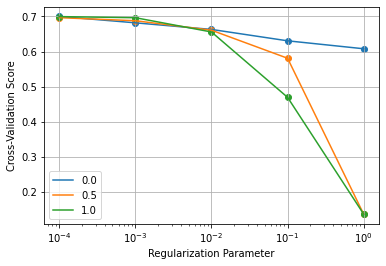

In [0]:
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list,
                          columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])

plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')
plt.show()

##Part E - Hyperparameter Tuning for Decision Tree
In this part we will use Grid Search and Cross Validation to perform hyperparameter tuning for the Decision Tree model, and then identify the optimal model.

Set up a grid search and cross-validation to perform hyperparameter tuning for the Decision Trees model.

In [0]:
dtree = DecisionTreeClassifier(featuresCol='features_dt', labelCol='Cover_Type', maxBins=38, seed=1)
 
param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
              .addGrid(dtree.minInstancesPerNode, [1, 2, 4])
             ).build()
 
cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, numFolds=5, 
                    evaluator=accuracy_eval, seed=1, parallelism=8)
 
cv_model = cv.fit(train)

Identify the optimal model found by the grid search algorithm and display the results.

In [0]:
dt_model = cv_model.bestModel
opt_maxDepth = dt_model.getMaxDepth()
opt_minInstancesPerNode = dt_model.getMinInstancesPerNode()
 
print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

Max CV Score: 0.7775
Optimal Depth: 16
Optimal MinInst: 1

Generate a plot to display the results of the cross-validation.

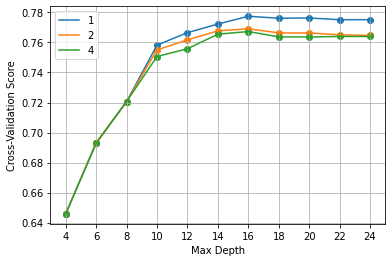

In [0]:
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list,
                          columns=['maxDepth', 'minInst', 'acc'])

for mi in cv_summary.minInst.unique():
    sel = cv_summary.minInst == mi
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])

plt.legend()
plt.grid()
plt.xticks(range(4,26,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')
plt.show()

Display the feature importance for each of the features used in the optimal Decision Tree model.

In [0]:
features = num_features + cat_features
pd.DataFrame({
    'feature':features,
    'importance':dt_model.featureImportances
})

Out[17]:

,feature,importance
0,Elevation,0.394260
1,Aspect,0.048116
2,Slope,0.026453
3,Horizontal_Distance_To_Hydrology,0.078278
4,Vertical_Distance_To_Hydrology,0.036748
5,Horizontal_Distance_To_Roadways,0.070875
6,Hillshade_9am,0.025840
7,Hillshade_Noon,0.023199
8,Hillshade_3pm,0.017314
9,Horizontal_Distance_To_Firepoints,0.079365


##Part F - Identifying and Evaluating the Final Model
In this part we will determine which of the two models appears to have better performance on out-of-sample records, and then use that model to evaulate the observations in the **test** dataframe.

Explain which of the two models - Linear Regression or Decision Trees - seems to perform better, using cross-validation scores as a basis for comparison. Provide justification for your answer.

In comparing the cross-validation (CV) scores, we have Linear Regression scoring **0.7001** (70.0%) and Decision Trees scoring **0.7775** (77.8%). The CV process, which evaluates each model using a k-fold cycle in which data segments are are excluded to simulate out-of-sample processing and the results then rolled into a composite average, is designed to simulate out-of-sample predictions and therfore can be used as a reasonably reliable tool for comparing the expected accuracy of various predictive models. Based on this, we conclude the 7.8% higher CV score for **Decision Trees** over Linear Regression makes it the optimal model for use with out-of-sample observations.

Using the optimal model selected, generate predictions for the **test** dataframe. Store the results in a new dataframe, and display the first 10 rows of results.

In [0]:
test_tree = dtree.fit(test)
test_pred = test_tree.transform(test)
test_pred.select('probability', 'prediction', 'Cover_Type').show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+----------+----------+
probability |prediction|Cover_Type|
+----------------------------------------------------------------------------------------------------------------------------------+----------+----------+
[0.0,0.00631911532385466,0.020537124802527645,0.42022116903633494,0.09636650868878358,0.009478672985781991,0.4470774091627172,0.0]|6.0 |6 |
[0.0,0.00631911532385466,0.020537124802527645,0.42022116903633494,0.09636650868878358,0.009478672985781991,0.4470774091627172,0.0]|6.0 |6 |
[0.0,0.00631911532385466,0.020537124802527645,0.42022116903633494,0.09636650868878358,0.009478672985781991,0.4470774091627172,0.0]|6.0 |6 |
[0.0,0.0,0.0,0.6666666666666666,0.3333333333333333,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.00631911532385466,0.020537124802527645,0.42022116903633494,0.09636650868878358,0.009478672985781991,0.4470774091627172,0.0]|6.0 |6 |
[0.0,0.0,0.0,0.6666666666666666,0.3333333333333333,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.00631911532385466,0.020537124802527645,0.42022116903633494,0.09636650868878358,0.009478672985781991,0.4470774091627172,0.0]|6.0 |6 |
[0.0,0.0,0.0,0.6666666666666666,0.3333333333333333,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.0873015873015873,0.8571428571428571,0.0,0.05555555555555555,0.0] |4.0 |3 |
[0.0,0.00631911532385466,0.020537124802527645,0.42022116903633494,0.09636650868878358,0.009478672985781991,0.4470774091627172,0.0]|6.0 |6 |
+----------------------------------------------------------------------------------------------------------------------------------+----------+----------+
only showing top 10 rows

Use the test prediction to evaluate the model's performance with out-of-sample data. Start by creating a RDD of prediction/label pairs, then use this to create an instance of MulticlassMetrics to generate and print the **accuracy** atrribute rounded to four decimal places.

In [0]:
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))
metrics = MulticlassMetrics(pred_and_labels)

print('Test Set Accuracy: ', round(metrics.accuracy,4))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
Test Set Accuracy: 0.6709

Display the Confusion Matrix for the test data.

In [0]:
labels = pred_and_labels.map(lambda x : int(x[1])).distinct().collect()
cm = metrics.confusionMatrix().toArray().astype(int)

pd.DataFrame(
    data=cm,
    columns=[1,2,3,4,5,6,7],
    index=[1,2,3,4,5,6,7]
)

Out[20]:

,1,2,3,4,5,6,7
1,345,31,1,0,41,4,35
2,133,83,0,0,169,17,3
3,0,0,90,25,22,294,0
4,0,0,4,392,0,75,0
5,1,14,1,0,379,11,0
6,0,0,5,14,27,354,0
7,58,1,0,0,2,0,371


Observations in the test set with Cover Type **3** were misclassified by the model as Cover Type **6** a total of **294** times. This was the most common type of misclassification in the test set.

Calculate and display the precision and recall for all label values as calculated on the test set, rounded to 4 decimal places.

In [0]:
print('Label       Precision   Recall')
print('------------------------------')

for i in [1,2,3,4,5,6,7]:
    print(f'{i:<12}{metrics.precision(i):<12.4f}{metrics.recall(i):.4f}')

Label Precision Recall
------------------------------
1 0.6425 0.7549
2 0.6434 0.2049
3 0.8911 0.2088
4 0.9095 0.8323
5 0.5922 0.9335
6 0.4689 0.8850
7 0.9071 0.8588

Interpret the precision and recall values from the test set.

1. **Which cover type is most likely to be correctly classified by our final model?**
 Cover Type 7 has the highest Precision value at **0.9071**, meaning that when the model predicted a square of land was Cover Type 7 and it really was Cover Type 7, it was correct 90.7% of the time. Its Recall value is also high at **0.8588**, meaning that of all the squares of land it predicted were Cover Type 7, it was correct 85.9% of the time.
2. **Which cover type is most likely to be misclassified by our final model?**
 Cover Type 6 has the lowest Precision value at **0.4689**, meaning that when the model predicted a square of land was Cover Type 6 and it really was Cover Type 6, it was correct 46.9% of the time. This is corroborated in that almost as many squares of Cover Type 3 were mistakenly predicted as Cover Type 6. dramatically reducing the precision.  Interestingly, its Recall value is much higher at **0.885**, meaning that of all the squares of land it predicted were Cover Type 6, it was correct 88.5% of the time; in other words, there were very few squares of Cover Type 6 that were misclassified as some other cover type.
3. **Which cover type has the greatest difference between its precision and recall? Explain the meaning of both of these values with respect to this cover type.**
 Precision is the proportion of positive results for a type that were actually correct for that type, while Recall is the proportion of all positive results for a type that were identified correctly as being that type. The differences are difficult to describe without an example: In the case of Cover Type 3, its Precision value is **0.8911** meaning that when the model predicted a square of land as Cover Type 3 and it actually is Cover Type 3, it was correct 89.1% of the time. Its Recall value is **0.2088** meaning that of all the squares of land the model predicted as being Cover Type 3, it was correct 20.9% of the time; as noted above, many of the squares of Cover Type 3 were misclassified as Cover Type 6. Put another way, if there were only 100 actual squares of Cover Type 3, it correctly identified 89 of them; but, if the model said there were 445 squares of Cover Type 3, only 20 percent (89) of them are actually Cover Type 3. The difference in the Precision and Recall values, **0.6823**, means that while it was accurately identifying areas within its own cover type, it was reaching very broadly and identifying many other areas incorrectly.